In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_matches = pd.read_csv('../data/preprocessed/preprocessed_1.csv')

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def train_and_evaluate(train_df, val_df, test_df):
    X_train = train_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_train = train_df["result_match"]

    X_val = val_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_val = val_df["result_match"]

    X_tst = test_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_tst = test_df["result_match"]

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    y_pred = model.predict(X_tst)

    f1 = f1_score(y_tst, y_pred)
    return f1

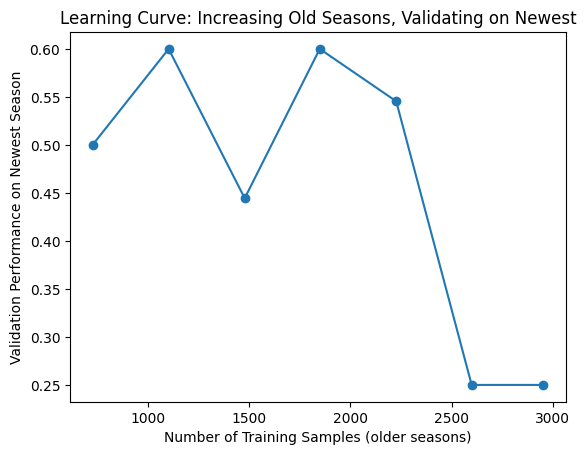

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

sorted_seasons = sorted(df_matches["season"].unique())
newest_season = sorted_seasons[-1]
older_seasons = sorted_seasons[:-1]

max_stage = df_matches.loc[df_matches["season"] == newest_season, "stage"].max()
penultimate_stage = max_stage - 1

train_sizes = []
performances = []

for i in range(1, len(older_seasons) + 1):
    train_seasons = sorted(older_seasons[-i:], reverse=True)

    train_df_older_seasons = df_matches[df_matches["season"].isin(train_seasons)]
    train_df_newest = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]
    train_df = pd.concat([train_df_older_seasons, train_df_newest], ignore_index=True)

    val_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == penultimate_stage)
        ]

    test_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == max_stage)
        ]

    performance_metric = train_and_evaluate(train_df, val_df, test_df)

    train_sizes.append(len(train_df))
    performances.append(performance_metric)

learning_curve_df = pd.DataFrame({
    'train_size': train_sizes,
    'performance': performances
})

plt.plot(learning_curve_df['train_size'], learning_curve_df['performance'], marker='o')
plt.xlabel('Number of Training Samples (older seasons)')
plt.ylabel('Validation Performance on Newest Season')
plt.title('Learning Curve: Increasing Old Seasons, Validating on Newest')
plt.show()

In [5]:
df_matches = df_matches.sort_values(by=["season", "stage", "date"])

train_seasons = sorted(older_seasons[-2:], reverse=True)

X_train_old = df_matches[df_matches["season"].isin(train_seasons)]
X_train_new = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]

df_train = pd.concat([X_train_old, X_train_new], ignore_index=True, )
df_val = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == penultimate_stage)].reset_index(
    drop=True)
df_tst = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == max_stage)].reset_index(drop=True)

X_trn = df_train.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_trn = df_train["result_match"]

X_val = df_val.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_val = df_val["result_match"]

X_tst = df_tst.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_tst = df_tst["result_match"]

In [13]:
X_trn.filter(like="difference")

,strength_difference,aggression_difference,acceleration_difference
0,-3.172727,2.377273,6.531818
1,-3.618182,-4.245455,9.718182
2,-16.312410,-28.707071,6.233045
3,-1.980519,11.966234,3.018182
4,-8.154545,-3.736364,-13.018182
...,...,...,...
1096,2.727273,1.381818,3.409091
1097,2.831169,13.755844,-16.979221
1098,-1.223377,7.057143,-6.945455
1099,0.272727,23.127273,-5.390909


In [14]:
(X_trn.filter(like="difference")
 .assign(result_match=y_trn)
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
 )

,strength_difference,aggression_difference,acceleration_difference,result_match
strength_difference,1.000000,0.571594,-0.331304,-0.004939
aggression_difference,0.571594,1.000000,-0.252638,0.034504
acceleration_difference,-0.331304,-0.252638,1.000000,0.057166
result_match,-0.004939,0.034504,0.057166,1.000000


In [8]:
X_trn[['team_strength_home', 'team_acceleration_home']]

,team_strength_home,team_acceleration_home
0,66.854545,79.677273
1,66.881818,77.972727
2,48.225974,80.389610
3,65.227273,79.436364
4,63.000000,70.263636
...,...,...
1096,72.090909,67.400000
1097,66.876623,63.584416
1098,70.027273,72.563636
1099,63.118182,73.354545


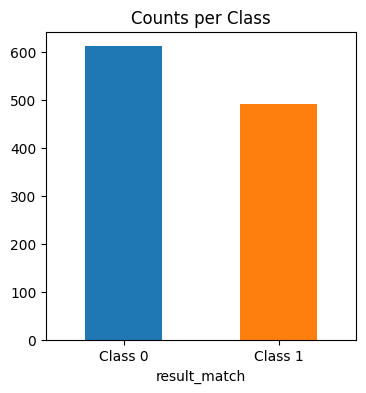

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
y_trn.value_counts().plot(
    kind='bar',
    ax=ax,
    color=['tab:blue', 'tab:orange']
)
ax.set_title('Counts per Class')
ax.set_xticklabels(['Class 0', 'Class 1'], rotation=0)
plt.show()

In [10]:
X_trn['strength_difference'].describe()

count    1101.000000
mean       -0.458971
std         8.666369
min       -26.836364
25%        -5.872727
50%        -0.200000
75%         5.037662
max        30.090909
Name: strength_difference, dtype: float64

/tmp/ipykernel_7573/1376494373.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('strength_diff_bin')['result_match']


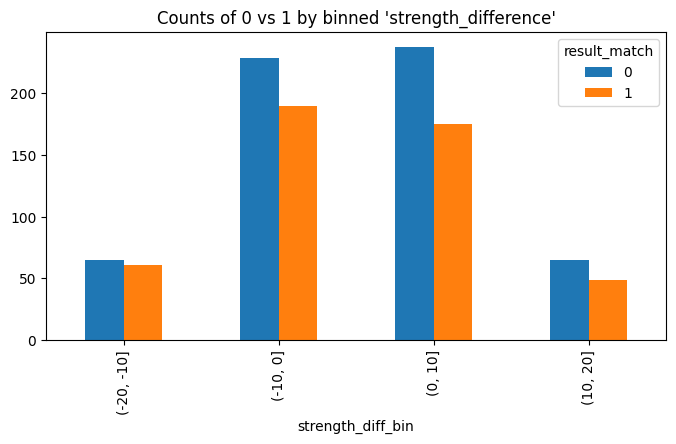

In [11]:
bins = pd.cut(
    X_trn['strength_difference'],
    bins=[-20, -10, 0, 10, 20]
)

X_train = X_trn.assign(result_match=y_trn)
X_train['strength_diff_bin'] = bins

fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .groupby('strength_diff_bin')['result_match']
    .value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
ax.set_title("Counts of 0 vs 1 by binned 'strength_difference'")
plt.show()

/tmp/ipykernel_7573/1376494373.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('strength_diff_bin')['result_match']


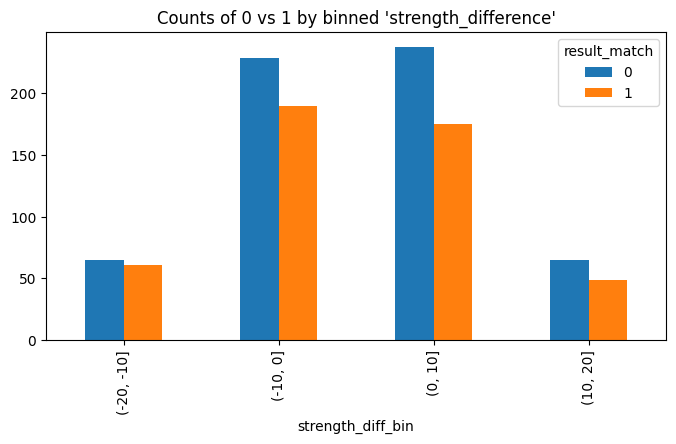

In [12]:
bins = pd.cut(
    X_trn['strength_difference'],
    bins=[-20, -10, 0, 10, 20]
)

X_train = X_trn.assign(result_match=y_trn)
X_train['strength_diff_bin'] = bins

fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .groupby('strength_diff_bin')['result_match']
    .value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
ax.set_title("Counts of 0 vs 1 by binned 'strength_difference'")
plt.show()